In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
df = pd.read_csv('../agent/cleaned_data/GOGL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1/2/2013,26.549999,30.150000,26.549999,29.900000,22.277349,94100.0
1,1/3/2013,29.900000,30.250000,29.350000,29.700001,22.128332,30600.0
2,1/4/2013,29.900000,32.000000,29.600000,31.950001,23.804724,59000.0
3,1/7/2013,31.950001,32.200001,31.100000,31.650000,23.581205,31700.0
4,1/8/2013,31.500000,31.850000,31.250000,31.299999,23.320431,25000.0


In [3]:
short_window = int(0.025 * len(df))
long_window = int(0.05 * len(df))

signals = pd.DataFrame(index=df.index)
signals['signal'] = 0.0

signals['short_ma'] = df['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
signals['long_ma'] = df['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

signals['signal'][short_window:] = np.where(signals['short_ma'][short_window:] 
                                            > signals['long_ma'][short_window:], 1.0, 0.0)   
signals['positions'] = signals['signal'].diff()

signals

,signal,short_ma,long_ma,positions
0,0.0,29.900000,29.900000,NaN
1,0.0,29.800000,29.800000,0.0
2,0.0,30.516667,30.516667,0.0
3,0.0,30.800000,30.800000,0.0
4,0.0,30.900000,30.900000,0.0
...,...,...,...,...
1758,0.0,5.673636,5.856364,0.0
1759,0.0,5.667500,5.856477,0.0
1760,0.0,5.655455,5.855114,0.0
1761,0.0,5.648864,5.857045,0.0


In [4]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 1000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    current_inventory = 0

    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory

    for i in range(real_movement.shape[0] - int(0.025 * len(df))):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest

In [5]:
states_buy, states_sell, total_gains, invest = buy_stock(df.Close, signals['positions'])

day 44: buy 1 units at price 34.500000, total balance 9965.500000
day 111, sell 1 units at price 32.099998, investment -6.956526 %, total balance 9997.599998,
day 154: buy 1 units at price 38.549999, total balance 9959.049999
day 231, sell 1 units at price 38.099998, investment -1.167317 %, total balance 9997.149998,
day 271: buy 1 units at price 47.500000, total balance 9949.649998
day 405, sell 1 units at price 57.650002, investment 21.368424 %, total balance 10007.299999,
day 567: buy 1 units at price 23.750000, total balance 9983.549999
day 617, sell 1 units at price 18.700001, investment -21.263155 %, total balance 10002.250000,
day 838: buy 1 units at price 4.350000, total balance 9997.900000
day 881, sell 1 units at price 3.450000, investment -20.689652 %, total balance 10001.350000,
day 928: buy 1 units at price 4.490000, total balance 9996.860000
day 1117, sell 1 units at price 6.250000, investment 39.198225 %, total balance 10003.110000,
day 1162: buy 1 units at price 8.29000

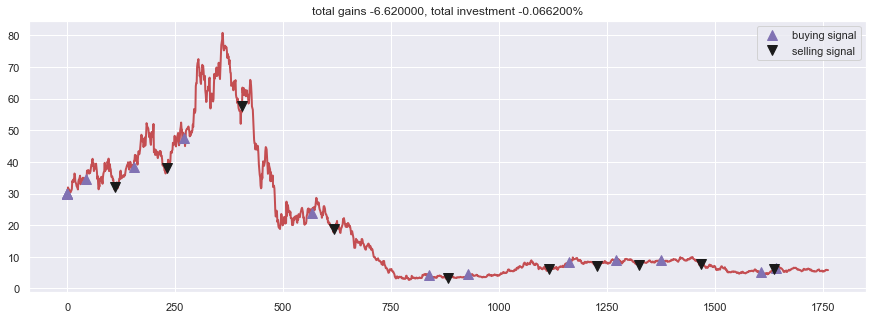

In [6]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()